In [226]:
from torch.autograd import Variable
import torch.nn as nn
import torch

x = torch.zeros(1,16,28,28)
v = Variable(x)
aConv = nn.Conv2d(16,16,3)

#theConv(v)

out_channels = aConv.weight.shape[0]
filter_size=3

myConv = nn.Conv2d(out_channels, out_channels, (filter_size, filter_size), padding=1, groups=out_channels, bias=False)

basic_m = torch.zeros(3, 3)
basic_m[1, 1] = 1
basic_m -= basic_m.mean()
myConv.weight.data = basic_m.expand_as(myConv.weight.data)







In [204]:
%pylab inline
import pandas as pd
import seaborn as sns


import os
import pickle
# compare running with  / without lateral inhibition
epochs = 300
n_options = 0
names = []
perfs = []
n_gpus = 4
cur_gpu = 0
debug_me = False
short_trials = 10
mode_ = 'local'
cmds_group_gpus = dict((i,[]) for i in range(n_gpus))
all_cmds = []

from itertools import product

trials = [0]
laterals = ['default','rand','none']
let_inhibition_learns = [False,True]
the_archs = ['dense','wrn']
datasets = ['100','10']

all_opts = list(product(trials,laterals,let_inhibition_learns,the_archs,datasets))

for trial,lateral,let_inhibition_learn,the_arch,dataset in all_opts:
    if the_arch!='dense' or dataset!='10':
        continue
    if lateral=='none' and let_inhibition_learn: 
        # nothing to learn where there's no "inhibition"
        continue                    
    if the_arch == 'dense':
        curOutDir = '~/checkpoints/cifar{}_inhibition/densenet-bc-100-12-IN_{}_IL_{}-run_{}'
        epochs = 300
    elif the_arch == 'wrn':
        curOutDir = '~/checkpoints/cifar{}_inhibition/wrn-28-10-IN_{}_IL_{}-run_{}'
        epochs = 200
    else:
        raise Exception('unsupported arch',the_arch)
    if debug_me:
        epochs=1
    if short_trials != -1:
        epochs =short_trials
    curOutDir = curOutDir.format(dataset,lateral,let_inhibition_learn,trial)
    ff = os.path.join(curOutDir,'log.txt')
#                   print ff
    #print ff
    if mode_ == 'local' and os.path.isfile(os.path.expanduser(ff)):
        continue
    ff = os.path.expanduser(ff)
    if True and os.path.isfile(os.path.expanduser(ff)):
        #print 'dfgdf'
        names.append('{}_{}_{}_{}'.format(lateral,let_inhibition_learn,trial,'cifar'+dataset))
        p = []
        #print lateral, let_inhibition_learn
        lines = open(ff).readlines()
        #print len(lines)
        for k in lines[1:]:
            #print k
            p.append(float(k.split()[-1]))
        perfs.append(p)
        #print p[-1]
        print '!!!!!!!!!!!!!!'
        print len(lines)
        if len(lines)>=epochs+1:
            continue
        else:
            print len(lines)
    n_options+=1
    if the_arch == 'dense':
        cmd = 'python cifar.py -a densenet --depth 100 --growthRate 12\
        --train-batch 64 --epochs {} --schedule 150 225 --wd 1e-4\
        --gamma 0.1 --checkpoint {}\
        --lateral-inhibition {} --learn-inhibition {} --dataset cifar{}'.format(epochs,curOutDir,lateral,
                                                             let_inhibition_learn,dataset)
    elif the_arch == 'wrn':

        #python cifar.py -a wrn --depth 28 --depth 28 --widen-factor 10 --drop 0.3 --epochs 200 --schedule 60 120 160 --wd 5e-4 --gamma 0.2 --checkpoint checkpoints/cifar10/WRN-28-10-drop

        cmd = 'python cifar.py -a wrn --depth 28 --widen-factor 10\
        --drop 0.3 --epochs {} --schedule 60 120 260 --wd 5e-4\
        --gamma 0.2 --checkpoint {}\
        --lateral-inhibition {} --learn-inhibition {} --dataset cifar{} '.format(epochs,curOutDir,lateral,
                                                             let_inhibition_learn,dataset)

    print cmd

    cmds_group_gpus[cur_gpu].append(cmd)
    cur_gpu+=1
    if cur_gpu == n_gpus:
        cur_gpu=0
    all_cmds.append(cmd)
print n_options

Populating the interactive namespace from numpy and matplotlib
python cifar.py -a densenet --depth 100 --growthRate 12        --train-batch 64 --epochs 10 --schedule 150 225 --wd 1e-4        --gamma 0.1 --checkpoint ~/checkpoints/cifar10_inhibition/densenet-bc-100-12-IN_default_IL_False-run_0        --lateral-inhibition default --learn-inhibition False --dataset cifar10
python cifar.py -a densenet --depth 100 --growthRate 12        --train-batch 64 --epochs 10 --schedule 150 225 --wd 1e-4        --gamma 0.1 --checkpoint ~/checkpoints/cifar10_inhibition/densenet-bc-100-12-IN_default_IL_True-run_0        --lateral-inhibition default --learn-inhibition True --dataset cifar10
python cifar.py -a densenet --depth 100 --growthRate 12        --train-batch 64 --epochs 10 --schedule 150 225 --wd 1e-4        --gamma 0.1 --checkpoint ~/checkpoints/cifar10_inhibition/densenet-bc-100-12-IN_rand_IL_False-run_0        --lateral-inhibition rand --learn-inhibition False --dataset cifar10
python cifar.py

In [79]:
def makeCommand(requiredFile,command):
    #cmd=outPath = os.path.join(all_cmds[0].split()[-7],'log.txt')
    cmd= \
    'FILE={} \n \
    if [ -f $FILE ]; then \n\
       echo "File $FILE exists." \n\
    else\n\
       echo "File $FILE does not exist." \n\
       {} \n \
    fi'.format(requiredFile,command)
    return cmd

In [175]:
'''
def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]
theChunks = list(chunks(all_cmds,int(ceil(float(len(all_cmds)/n_gpus))))
                 
int(ceil(float(len(all_cmds)/n_gpus)))
'''

theChunks = map(list,np.array_split(all_cmds,n_gpus))
#map(len,theChunks)

In [176]:
for i,chunk in enumerate(theChunks):
    #chunk = chunk[:1]
    print '(',
    for ii,c in enumerate(chunk):
        #c = 'touch {}'.format(str(ii).zfill(5))\
        
        required_file = c.split()[-7]
        command_stuff = '{} --gpu_id {}'.format(c,i)
        cmd = makeCommand(required_file,command_stuff)
        print cmd,
        if ii < len(chunk)-1:
            print ' ;',        
    print ') &'

( FILE=~/checkpoints/cifar100_inhibition/wrn-28-10-IN_default_IL_False-run_0 
     if [ -f $FILE ]; then 
       echo "File $FILE exists." 
    else
       echo "File $FILE does not exist." 
       python cifar.py -a wrn --depth 28 --widen-factor 10                        --drop 0.3 --epochs 200 --schedule 60 120 260 --wd 5e-4                        --gamma 0.2 --checkpoint ~/checkpoints/cifar100_inhibition/wrn-28-10-IN_default_IL_False-run_0                        --lateral-inhibition default --learn-inhibition False --dataset cifar100  --gpu_id 0 
     fi  ; FILE=~/checkpoints/cifar10_inhibition/wrn-28-10-IN_default_IL_False-run_0 
     if [ -f $FILE ]; then 
       echo "File $FILE exists." 
    else
       echo "File $FILE does not exist." 
       python cifar.py -a wrn --depth 28 --widen-factor 10                        --drop 0.3 --epochs 200 --schedule 60 120 260 --wd 5e-4                        --gamma 0.2 --checkpoint ~/checkpoints/cifar10_inhibition/wrn-28-10-IN_default_IL_Fa

In [177]:
a = pickle.load(open('/home/amir/Downloads/results.pkl'))

In [182]:
aa.keys()

['let_inhibition_learn', 'lateral', 'dataset', 'trial', 'flines', 'arch']

'lateral'

In [184]:
aa['let_inhibition_learn']

False

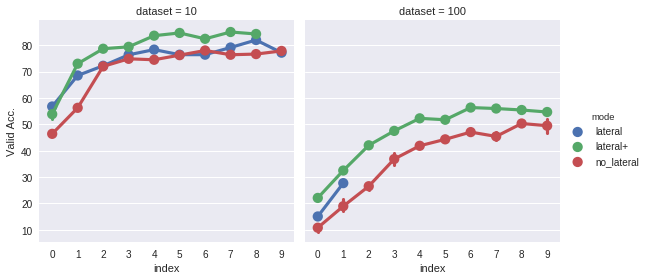

In [196]:
from StringIO import StringIO
z = []
for aa in a:
    
    theTable = L = '\n'.join(map(str.strip,aa['flines']))
    aa_table = pd.read_table(StringIO(L)).reset_index()
    aa_table['arch']=aa['arch']    
    if aa['arch']=='dense':
        continue
    #if aa['dataset']=='100':
    #    continue
        
    s = ''
    if aa['lateral']=='none':
        s = 'no_lateral'
    else:
        s = 'lateral'
    if aa ['let_inhibition_learn']:
        s+='+'
    aa_table['mode'] = s
        
    aa_table['let_inhibition_learn']=aa['let_inhibition_learn']
    aa_table['let_inhibition_learn']=aa['let_inhibition_learn']
    aa_table['lateral']=aa['lateral']
    aa_table['dataset']=aa['dataset']
    aa_table['trial']=aa['trial']
    
    z.append(aa_table[:10])
    #z.append(aa_table)#[-50:])
    #break
    
z = pd.concat(z)

#g=sns.factorplot(data=z,x='index',y='Valid Acc.',col='dataset',hue='lateral')
g=sns.factorplot(data=z,x='index',y='Valid Acc.',col='dataset',hue='mode')
#(data=aa_table[::10],x='index',y='Valid Acc.',aspect=2)
#g.set(xticklabels=[])
#
    

In [31]:
#z.groupby(['dataset','lateral','let_inhibition_learn']).max()

index  Learning Rate  Train Loss  \
dataset lateral let_inhibition_learn                                     
10      default False                    24            0.1    1.477901   
                True                     24            0.1    1.337913   
        none    False                    24            0.1    1.683257   
100     default False                    24            0.1    3.743640   
                True                     24            0.1    3.673698   
        none    False                    24            0.1    4.012393   

                                      Valid Loss  Train Acc.  Valid Acc.  \
dataset lateral let_inhibition_learn                                       
10      default False                   1.240327      87.624       84.56   
                True                    0.961783      91.156       88.69   
        none    False                   1.495572      89.930       87.26   
100     default False                   3.323889      72.008       63.55   
                True                    3.191444      73.488       65.19   
        none    False                   3.998455      70.706       62.91   

                                       arch  
dataset lateral let_inhibition_learn         
10      default False                   wrn  
                True                  dense  
        none    False                   wrn  
100     default False                   wrn  
                True                    wrn  
        none    False                   wrn

In [150]:

a[0]['flines']

'0.100000\t2.891201\t2.842624\t26.512000\t28.330000\t\n'

In [146]:

#pd.read_table(a[0]['flines'])

ValueError: Invalid file path or buffer object type: <type 'list'>

( python cifar.py -a wrn --depth 28 --widen-factor 10                        --drop 0.3 --epochs 200 --schedule 60 120 260 --wd 5e-4                        --gamma 0.2 --checkpoint ~/checkpoints/cifar100_inhibition/wrn-28-10-IN_default_IL_False-run_0                        --lateral-inhibition default --learn-inhibition False --dataset cifar100  --gpu_id 0  ; python cifar.py -a wrn --depth 28 --widen-factor 10                        --drop 0.3 --epochs 200 --schedule 60 120 260 --wd 5e-4                        --gamma 0.2 --checkpoint ~/checkpoints/cifar10_inhibition/wrn-28-10-IN_default_IL_False-run_0                        --lateral-inhibition default --learn-inhibition False --dataset cifar10  --gpu_id 0  ; python cifar.py -a densenet --depth 100 --growthRate 12                        --train-batch 64 --epochs 300 --schedule 150 225 --wd 1e-4                        --gamma 0.1 --checkpoint ~/checkpoints/cifar100_inhibition/densenet-bc-100-12-IN_default_IL_True-run_0                 

In [117]:
%pylab inline



Populating the interactive namespace from numpy and matplotlib


/home/amir/anaconda3/envs/universe/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


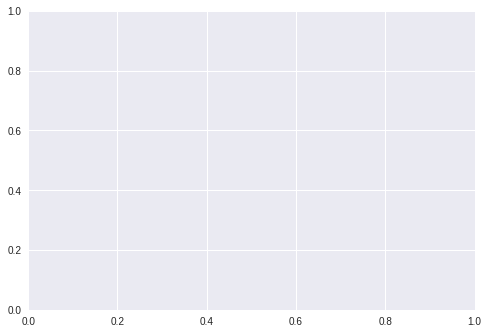

In [126]:
sns.set_palette(sns.color_palette("Set1"))
for n,p in zip(names,perfs):
    #p=np.maximum.accumulate(p)
    #if len(p) != epochs:
    #    continue
    z=0
    plot(p[z:z+50],label=n)
#ylim(90,96)
legend()

In [204]:
cmd

'python cifar.py -a densenet --depth 100 --growthRate 12        --train-batch 64 --epochs 10 --schedule 150 225 --wd 1e-4        --gamma 0.1 --checkpoint /home/amir/checkpoints/cifar10_inhibition/densenet-bc-100-12-IN_default-run_2        --lateral-inhibition default'

In [203]:
print curOutDir

/home/amir/checkpoints/cifar10_inhibition/densenet-bc-100-12-IN_default-run_2


In [199]:
cmd

'python cifar.py -a densenet --depth 100 --growthRate 12        --train-batch 64 --epochs 10 --schedule 150 225 --wd 1e-4        --gamma 0.1 --checkpoint default        --lateral-inhibition default'

In [110]:
# Pack X and Y into a single 3-dimensional array
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y
Z = z(X,Y)

In [98]:
Z = Z-Z.mean()

In [ ]:
# Let's define two gaussians.

In [94]:
Z.sum()

0.025671842599306084

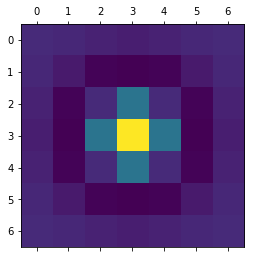

In [109]:
matshow(Z)

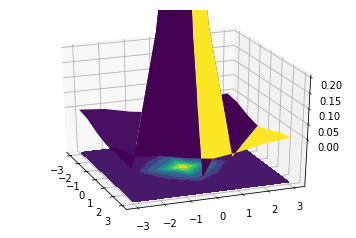

In [111]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, Z, rstride=3, cstride=3, linewidth=1, antialiased=True,
               cmap=cm.viridis)
cset = ax.contourf(X, Y, Z, zdir='z', offset=-0.15, cmap=cm.viridis)

# Adjust the limits, ticks and view angle
ax.set_zlim(-0.15,0.2)
ax.set_zticks(np.linspace(0,0.2,5))
ax.view_init(27, -21)

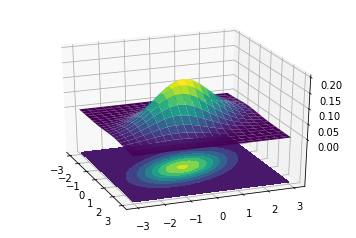

In [18]:
# import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

# Our 2-dimensional distribution will be over variables X and Y
N = 60
X = np.linspace(-3, 3, N)
Y = np.linspace(-3, 3, N)
X, Y = np.meshgrid(X, Y)

# Mean vector and covariance matrix
mu = np.array([0., 0.])
Sigma = np.array([[ 1. , -0.5], [-0.5,  1.5]])

# Pack X and Y into a single 3-dimensional array
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

def multivariate_gaussian(pos, mu, Sigma):
    """Return the multivariate Gaussian distribution on array pos.

    pos is an array constructed by packing the meshed arrays of variables
    x_1, x_2, x_3, ..., x_k into its _last_ dimension.

    """

    n = mu.shape[0]
    Sigma_det = np.linalg.det(Sigma)
    Sigma_inv = np.linalg.inv(Sigma)
    N = np.sqrt((2*np.pi)**n * Sigma_det)
    # This einsum call calculates (x-mu)T.Sigma-1.(x-mu) in a vectorized
    # way across all the input variables.
    fac = np.einsum('...k,kl,...l->...', pos-mu, Sigma_inv, pos-mu)

    return np.exp(-fac / 2) / N

# The distribution on the variables X, Y packed into pos.
Z = multivariate_gaussian(pos, mu, Sigma)

# Create a surface plot and projected filled contour plot under it.
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, Z, rstride=3, cstride=3, linewidth=1, antialiased=True,
                cmap=cm.viridis)

cset = ax.contourf(X, Y, Z, zdir='z', offset=-0.15, cmap=cm.viridis)

# Adjust the limits, ticks and view angle
ax.set_zlim(-0.15,0.2)
ax.set_zticks(np.linspace(0,0.2,5))
ax.view_init(27, -21)

plt.show()

In [8]:
!mkdir ca_frames

0/400
10/400
20/400
30/400
40/400
50/400
60/400
70/400
80/400
90/400
100/400
110/400
120/400
130/400
140/400
150/400
160/400
170/400
180/400
190/400
200/400
210/400
220/400
230/400
240/400
250/400
260/400
270/400
280/400
290/400
300/400
310/400
320/400
330/400
340/400
350/400
360/400
370/400
380/400
390/400


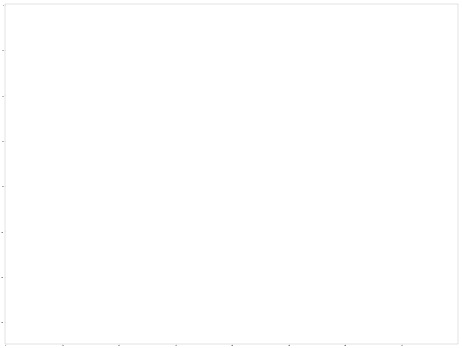

In [9]:
import numpy as np
from scipy.signal import convolve2d
import matplotlib.pyplot as plt

def ca_step(X):
    """Evolve the maze by a single CA step."""

    K = np.ones((3, 3))
    n = convolve2d(X, K, mode='same', boundary='wrap') - X
    return (n == 3) | (X & ((n > 0) & (n < 6)))

# Maze size
nx, ny = 200, 150
X = np.zeros((ny, nx), dtype=np.bool)
# Size of initial random area (must be even numbers)
mx, my = 20, 16

# Initialize a patch with a random mx x my region
r = np.random.random((my, mx)) > 0.75
X[ny//2-my//2:ny//2+my//2, nx//2-mx//2:nx//2+mx//2] = r

# Total number of iterations
nit = 400
# Make an image every ipf iterations
ipf = 10

# Figure dimensions (pixels) and resolution (dpi)
width, height, dpi = 600, 450, 10
fig = plt.figure(figsize=(width/dpi, height/dpi), dpi=dpi)
ax = fig.add_subplot(111)

for i in range(nit):
    X = ca_step(X)
    if not i % ipf:
        print('{}/{}'.format(i,nit))
        im = ax.imshow(X, cmap=plt.cm.binary, interpolation='nearest')
        plt.axis('off')
        plt.savefig('ca_frames/_img{:04d}.png'.format(i), dpi=dpi)
        plt.cla()